# 2022 DACON 따릉이 수요 예측

1. Preprocess
- 데이터 분포 확인
- 결측값 채우기
- Feature 추가하기

2. Predict
- 모델 구성
- 실험

3. 실험 환경
- cpu: intel core i5-7500
- anaconda python 3.8
- requirements.txt 파일 참고

In [306]:
# !pip freeze > requirements.txt

# 1. Preprocess

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 분포 확인

In [186]:
"""
데이터 로드
"""
train = pd.read_csv("./dataset/raw/train.csv")
test = pd.read_csv("./dataset/raw/test.csv")
submit = pd.read_csv("./dataset/raw/sample_submission.csv")

In [187]:
print("==== Raw train.csv ====")
train[:3]

==== Raw train.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156


In [188]:
print("==== Raw test.csv ====")
test[:3]

==== Raw test.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1
1,2021-01-02,NaN,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4
2,2021-01-03,NaN,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5


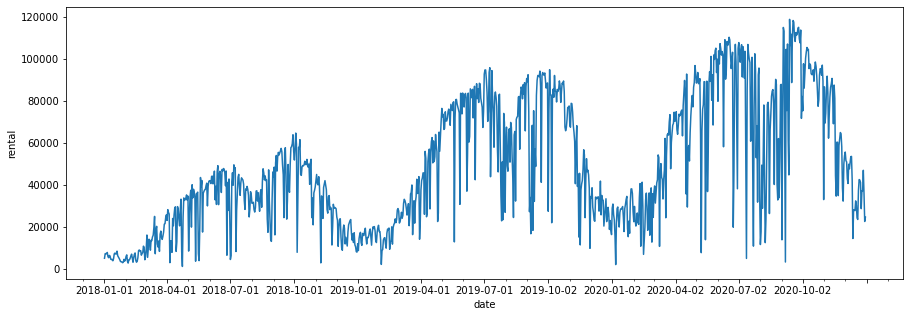

In [189]:
# 시간에 따른 데이터 추이 시각화
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline
# x:date, y:rent
xs = train['date'].to_list()
ys = train['rental'].to_list()


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
plt.xlabel("date")
plt.ylabel("rental")
# ax = fig.add_subplot()
ax.plot(xs, ys)
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # 날짜 표시 형식
ax.xaxis.set_major_locator(MonthLocator(interval=3))     # 3개월마다 눈금 표시
ax.xaxis.set_minor_locator(MonthLocator(interval=1)) ## 1개월마다 서브 눈금을 표시한다.

# 매년 증가하는 추세를 보임

In [190]:
"""
연, 월, 일 분리 후 date 컬럼 제거
plot 시각화를 위해 date는 따로 저장
"""
train_date = train['date']
test_date = test['date']

# Train date 분리
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train = train.drop(['date'], axis=1)
print("Train columns: ", train.columns)

# Test date 분리
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test = test.drop(['date'], axis=1)
print("Test columns: ", test.columns)

Train columns:  Index(['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'rental', 'year', 'month', 'day'],
      dtype='object')
Test columns:  Index(['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'year', 'month', 'day'],
      dtype='object')


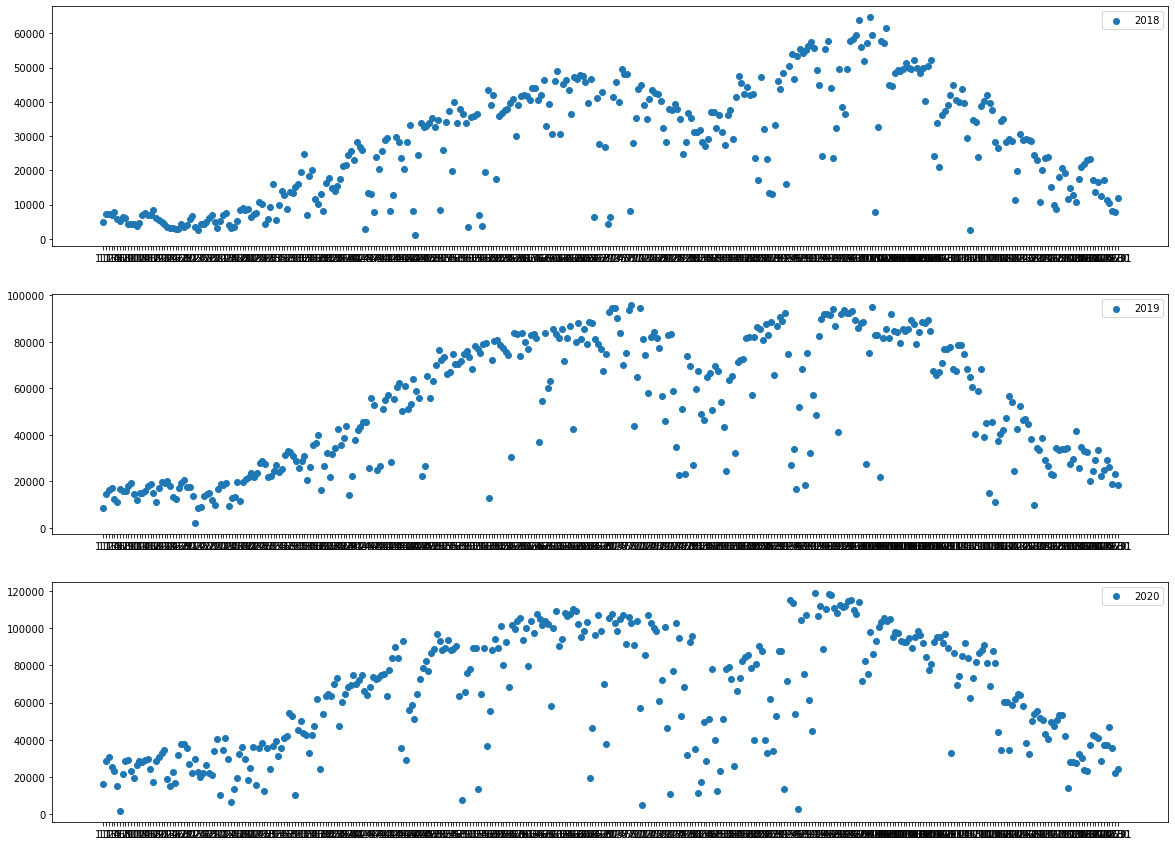

In [193]:
# 연도별 렌트량 출력
# train_split: 연도별로 train을 자른 것
%matplotlib inline

fig, ax = plt.subplots(3, 1, figsize=(20, 15))
train_split = {}

for i, year in enumerate([2018, 2019, 2020]):
    train_split[year] = train[train['year'] == year]    # 해당 연도 df만 가져옴
    x = train_split[year]['month'].map(str) + ' ' + train_split[year]['day'].map(str)
    y = train_split[year]['rental']

    ax[i].scatter(x, y)
    ax[i].legend([year])

# %matplotlib tk를 이용해 새 창에서 figure를 띄워보면 6월,10월이 가장 많은 때이고, 두 개의 극대값을 형성하는 모양임을 알 수 있다.
# 매년 증가폭이 있지만 유사한 양상을 보인다.

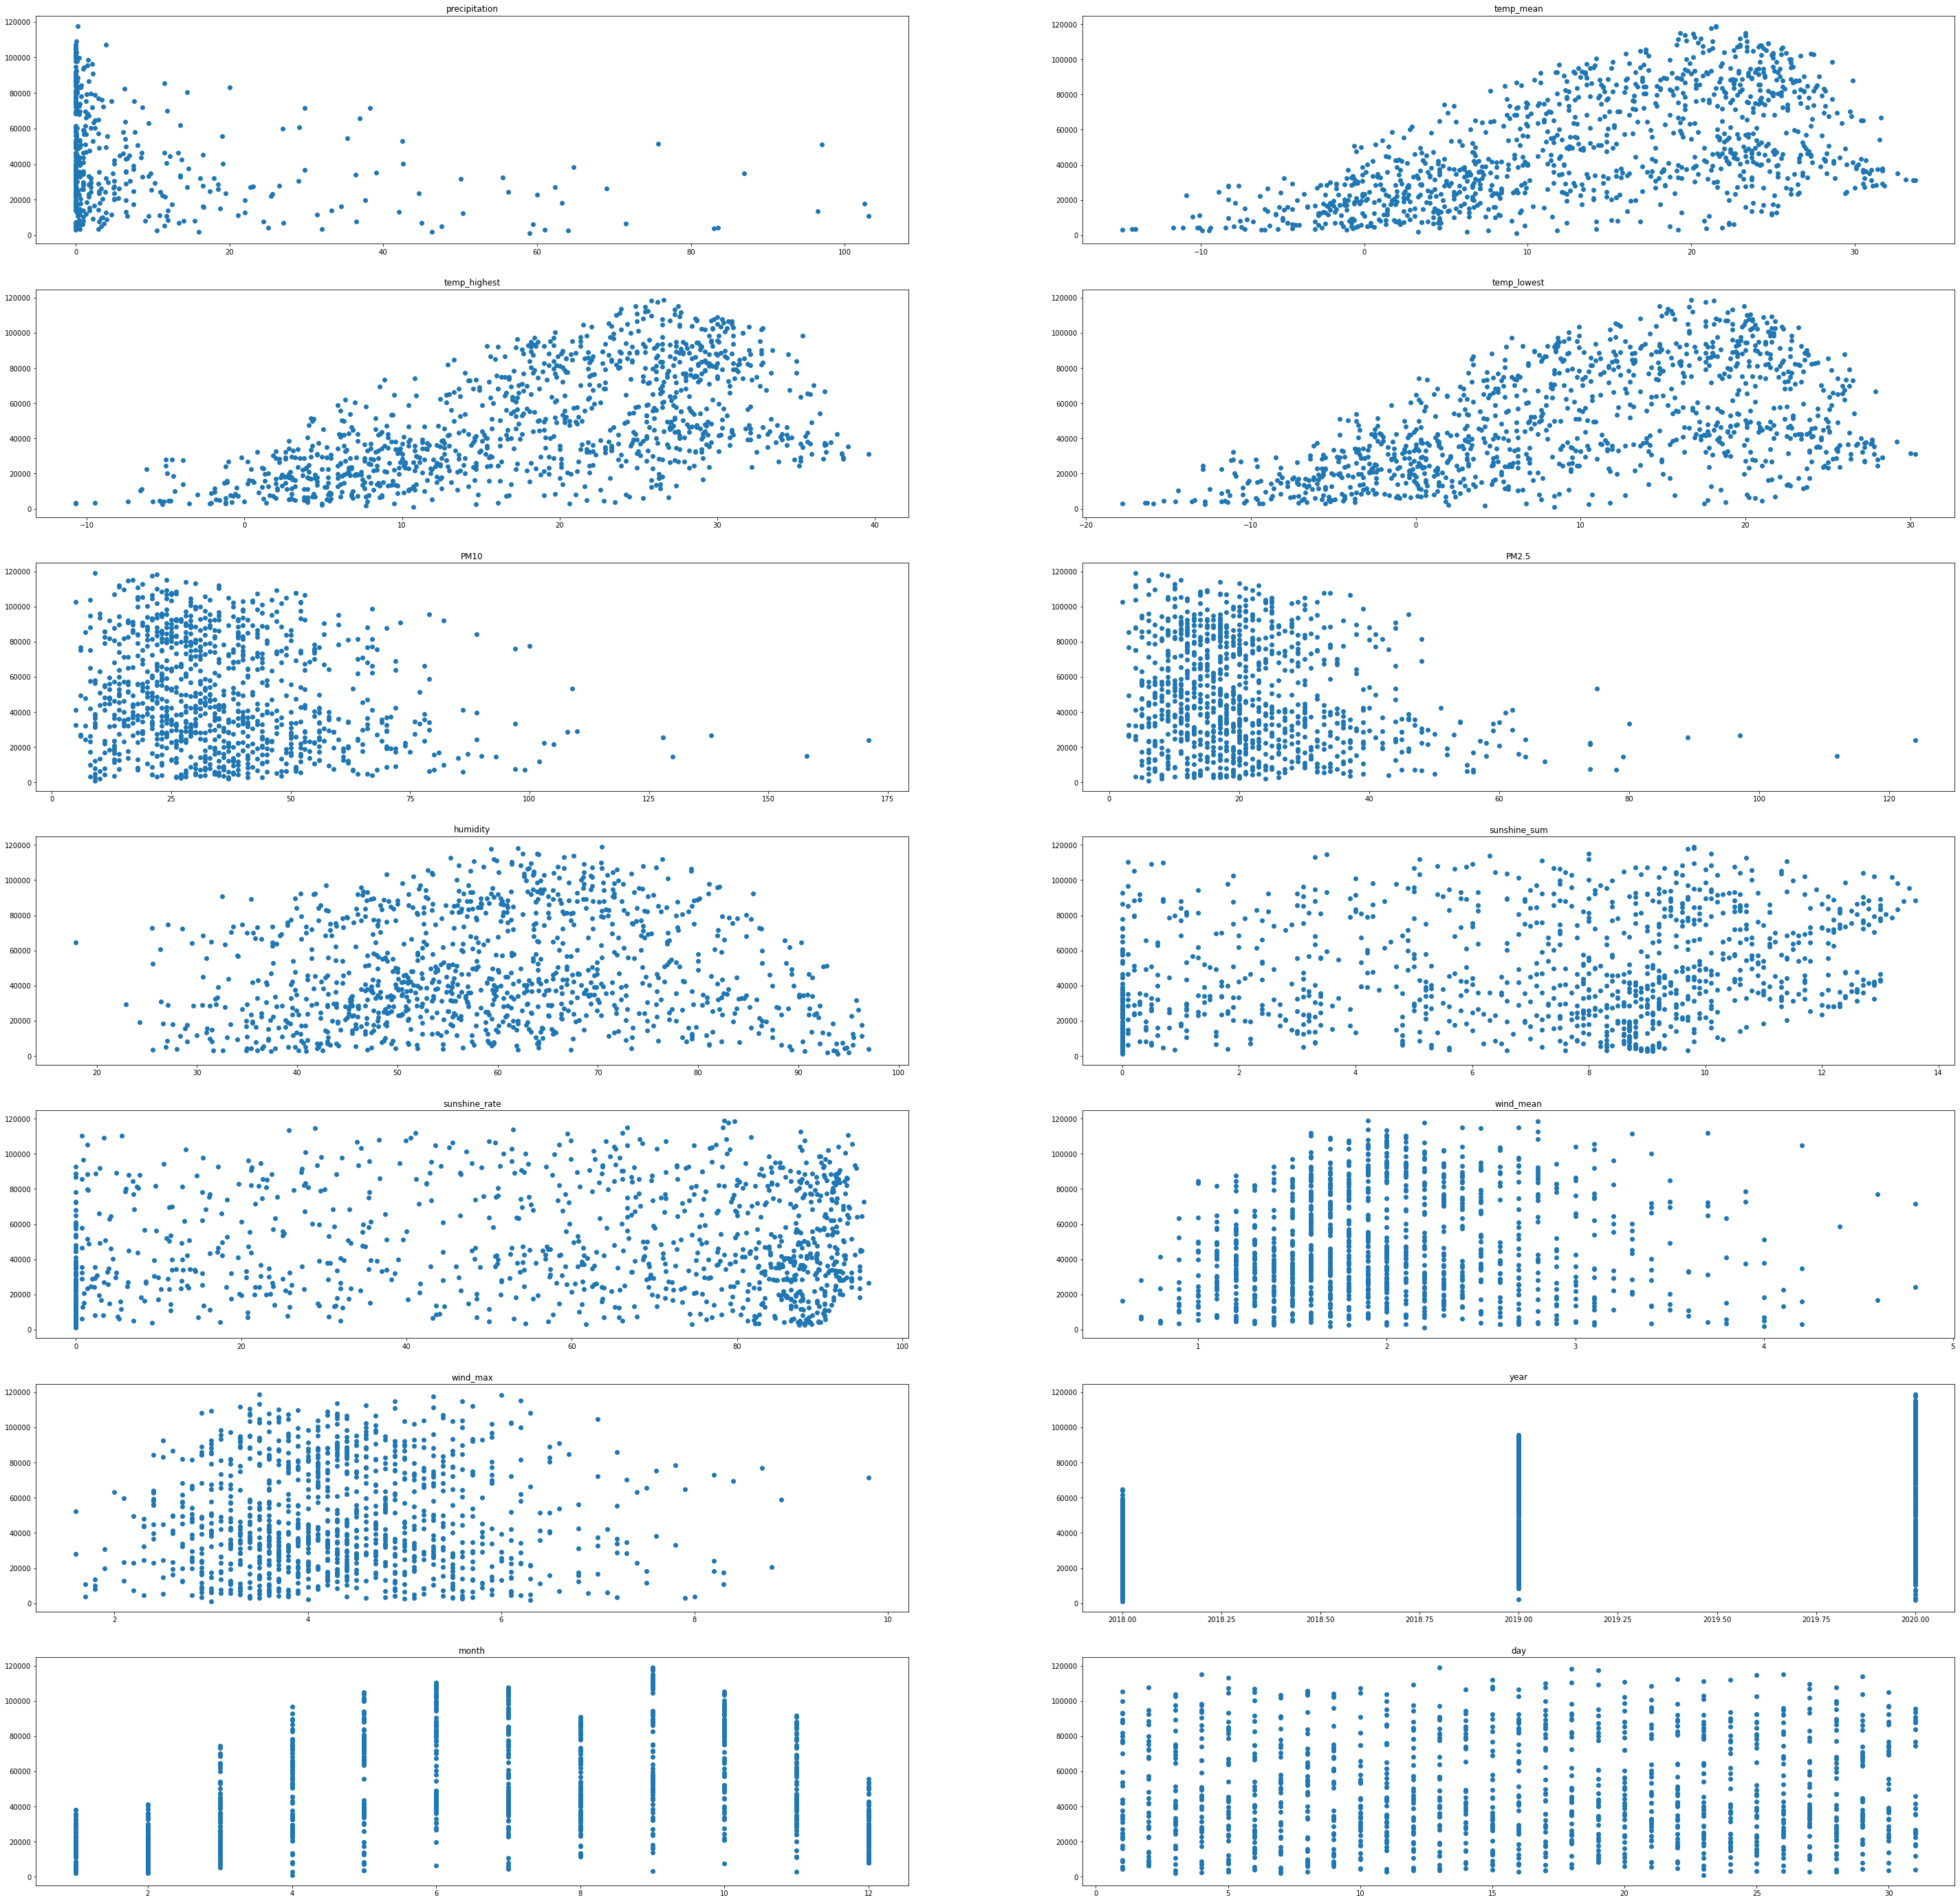

In [194]:
"""
feature와 rental의 관계
"""

columns = ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'year', 'month', 'day']

fig, ax = plt.subplots(7, 2, figsize=(50,50))
 
# scatter plot
for i, col in zip(range(14), columns):
    j = i%2
    i = int(i/2)
    ax[i][j].scatter(train[col], train['rental'])
    ax[i][j].set(title=col)
    
    
# 서로 비슷한 분포를 보이는 feature들이 있음을 알 수 있음 - (최고온도, 최저온도, 평균온도), (PM10, PM2.5), (sunshine_rate, sunshine_sum)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
precipitation,1.000000,0.236759,0.191100,0.269249,-0.309913,-0.267352,0.569966,-0.377028,-0.377292,0.049306,0.157582,-0.279097,0.025600,0.082501,-0.029798
temp_mean,0.236759,1.000000,0.989381,0.989154,-0.337365,-0.281824,0.457462,-0.016656,-0.226370,-0.146361,-0.111282,0.563741,0.010501,0.229226,0.010988
temp_highest,0.191100,0.989381,1.000000,0.961775,-0.305294,-0.260756,0.377355,0.085341,-0.128156,-0.175558,-0.129259,0.591219,-0.003496,0.213061,0.012771
temp_lowest,0.269249,0.989154,0.961775,1.000000,-0.359186,-0.293038,0.529384,-0.108174,-0.307688,-0.116424,-0.093636,0.524770,0.019899,0.233542,0.009255
PM10,-0.309913,-0.337365,-0.305294,-0.359186,1.000000,0.905441,-0.211069,0.057230,0.115529,-0.118120,-0.032315,-0.179880,0.032338,-0.230274,-0.026712
PM2.5,-0.267352,-0.281824,-0.260756,-0.293038,0.905441,1.000000,-0.072204,-0.019315,0.034618,-0.207875,-0.120697,-0.209074,0.035106,-0.222941,-0.043512
humidity,0.569966,0.457462,0.377355,0.529384,-0.211069,-0.072204,1.000000,-0.618732,-0.664106,-0.018888,-0.003313,0.088708,0.150492,0.227960,0.006279
sunshine_sum,-0.377028,-0.016656,0.085341,-0.108174,0.057230,-0.019315,-0.618732,1.000000,0.958264,0.023203,0.041256,0.233699,-0.099207,-0.070238,-0.011515
sunshine_rate,-0.377292,-0.226370,-0.128156,-0.307688,0.115529,0.034618,-0.664106,0.958264,1.000000,0.027294,0.037391,0.118870,-0.078575,-0.022317,-0.010777
wind_mean,0.049306,-0.146361,-0.175558,-0.116424,-0.118120,-0.207875,-0.018888,0.023203,0.027294,1.000000,0.816071,0.071454,0.379364,-0.065497,0.007179


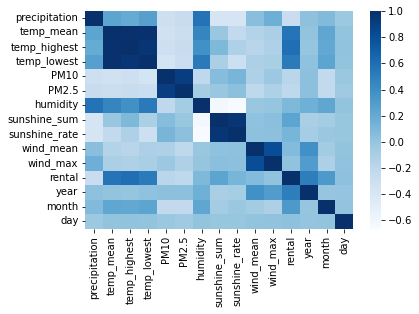

In [195]:
"""
상관계수
"""
import seaborn as sns
sns.heatmap(train.corr(), cmap='Blues')

train.corr()

## 결측값 채우기
- Precipitation (강수량)
- Sunshine sum (일조합)
- PM10, PM2.5 (미세먼지 농도)

In [196]:
# Train 데이터 결측치 개수 표시
print("[Train 데이터 결측치 표시]")
print(train[train.columns].isnull().sum())
print()

# Test 데이터 결측치 표시
print("[Test 데이터 결측치 표시]")
print(test[test.columns].isnull().sum())

[Train 데이터 결측치 표시]
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10              67
PM2.5             68
humidity           0
sunshine_sum       5
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
year               0
month              0
day                0
dtype: int64

[Test 데이터 결측치 표시]
precipitation    205
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       1
sunshine_rate      0
wind_mean          0
wind_max           0
year               0
month              0
day                0
dtype: int64


### Precipitation

In [197]:
train.corr()['precipitation'].argsort()

precipitation     8
temp_mean         7
temp_highest      4
temp_lowest      11
PM10              5
PM2.5            14
humidity         12
sunshine_sum      9
sunshine_rate    13
wind_mean        10
wind_max          2
rental            1
year              3
month             6
day               0
Name: precipitation, dtype: int64

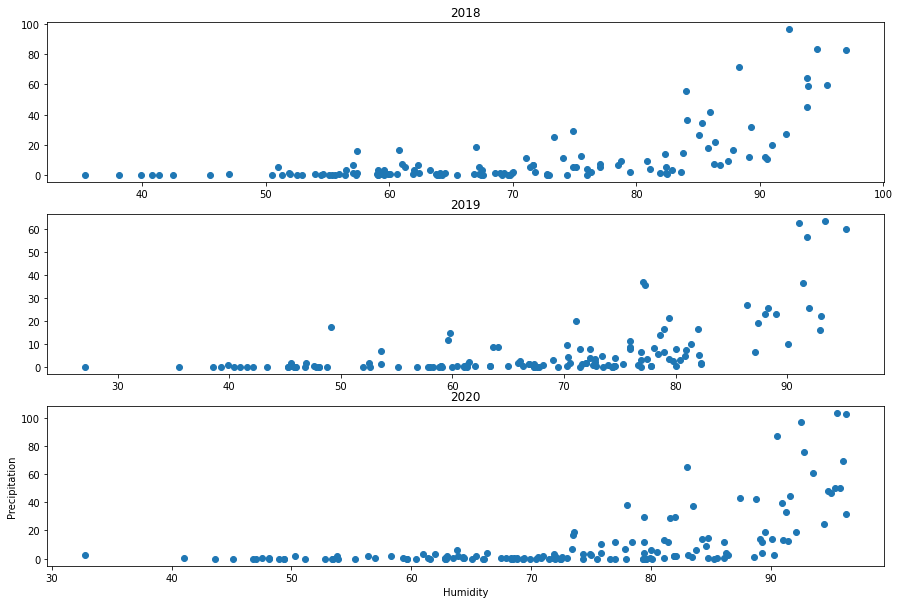

In [202]:
"""
Train 강수량 결측치
"""
# 강수량과 습도 사이 관계
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

is_null_pre = {}
train_split = {}

for i, year in enumerate([2018, 2019, 2020]):
    train_split[year] = train[train['year'] == year]    # 해당 연도 df만 가져옴
    is_null_pre[year] = train_split[year]['precipitation'].isnull()

    x = train_split[year]['humidity'].loc[is_null_pre[year] == False]
    y = train_split[year]['precipitation'].loc[is_null_pre[year] == False]
    
    ax[i].scatter(x, y)
    ax[i].set(title=year)
    plt.xlabel("Humidity")
    plt.ylabel("Precipitation")


# 지수함수 모양을 따르므로 피팅해보기로 함

[0.19706879] [-14.41451694]
[0.22106558] [-16.87543765]
[0.20295156] [-16.69954629]


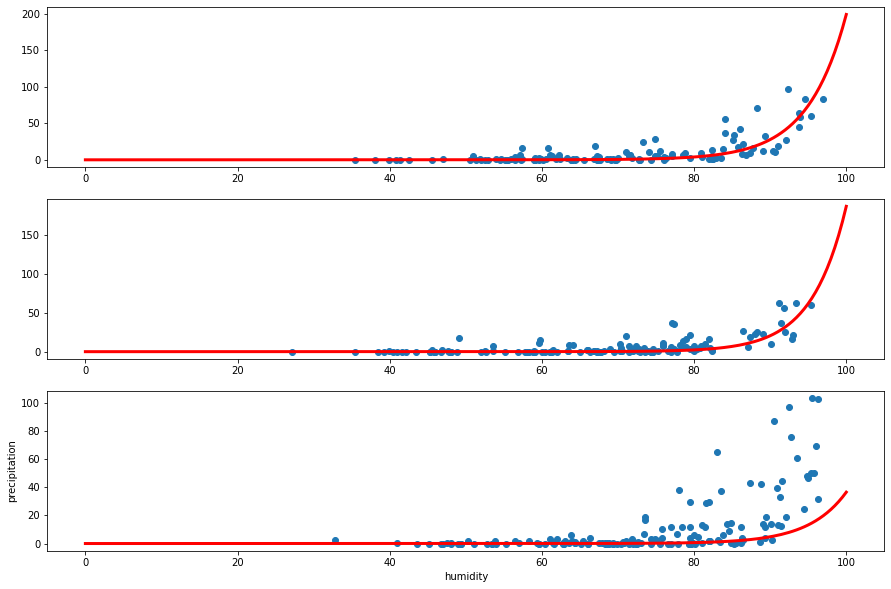

In [203]:
"""
지수함수 피팅
"""

fig, ax = plt.subplots(3, 1, figsize=(15, 10))
nan_pred = {}


for i, year in enumerate([2018, 2019, 2020]):
    df = train_split[year]
    null = is_null_pre[year]

    x = np.array(df['humidity'].loc[null == False].values.tolist()).reshape(-1, 1)
    y = df['precipitation'].loc[null == False] + 0.0001
    y = np.array(y.map(np.log)).reshape(-1, 1)   # 값이 0인 데이터 방지 0.01

    model = LinearRegression()
    model.fit(x, y)

    xs = np.linspace(0, 100, 200)
    ys = np.exp(xs*model.coef_[0] + model.intercept_) - 0.0001

    plt.xlabel("humidity")
    plt.ylabel("precipitation")
    ax[i].scatter(df['humidity'].loc[null == False].values.tolist(), df['precipitation'].loc[null == False])
    ax[i].plot(xs, ys, 'r-', lw=3)

    print(model.coef_[0], model.intercept_)

    xs = np.array(df['humidity'].loc[null].values.tolist())
    nan_pred[year] = np.exp(xs*model.coef_[0] + model.intercept_) - 0.0001

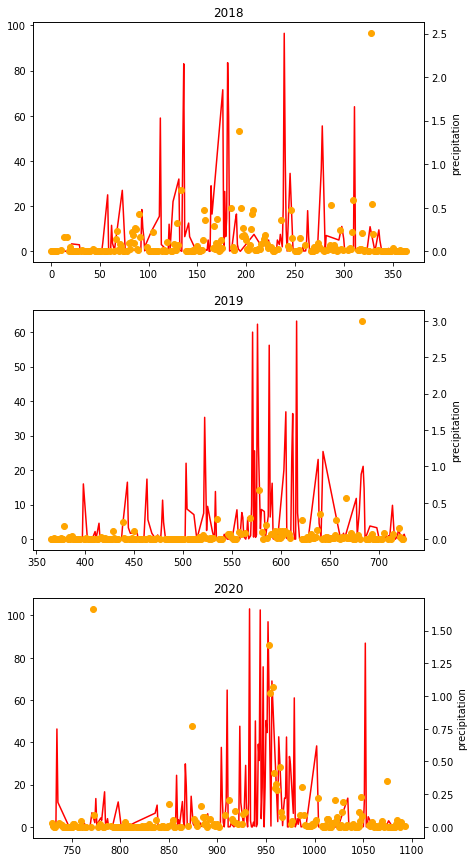

In [205]:
# 지수함수 피팅 결과 (주황색 점)
fig, ax = plt.subplots(3, 1, figsize=(7, 15))


for i, year in enumerate([2018, 2019, 2020]):
    df = train_split[year]
    null = is_null_pre[year]
    pred = nan_pred[year]
    
    value_idx = null[null == False].index  # null 값이 아닌 것 인덱스
    null_idx = null[null == True].index    # null 인 것 인덱스
    
    y = df['precipitation'].loc[null == False].values.tolist()
    ax[i].plot(value_idx, y, color='red')

    ax1 = ax[i].twinx()
    ax1.scatter(null_idx, pred, color='orange')
    plt.xlabel("date")
    plt.ylabel("precipitation")
    ax[i].set_title(year)
    
    
# 빨간색은 원래 강수량 분포, 주황색은 지수함수로 결측치를 피팅한 결과

In [206]:
import warnings
pd.set_option('mode.chained_assignment', None)  # SettingWithCopyWarning 경고 무시
warnings.simplefilter(action='ignore', category=[FutureWarning, UserWarning, ]) # FutureWarning 제거

In [207]:
nan_preds = []
for year in [2018, 2019, 2020]:
    nan_preds.extend(nan_pred[year])

is_null = train['precipitation'].isnull()
train['precipitation'].loc[is_null] = nan_preds

In [210]:
train['precipitation'].isnull().sum()      # Train 강수량 결측치 0 확인

0

[0.19337742] [-15.71009227]


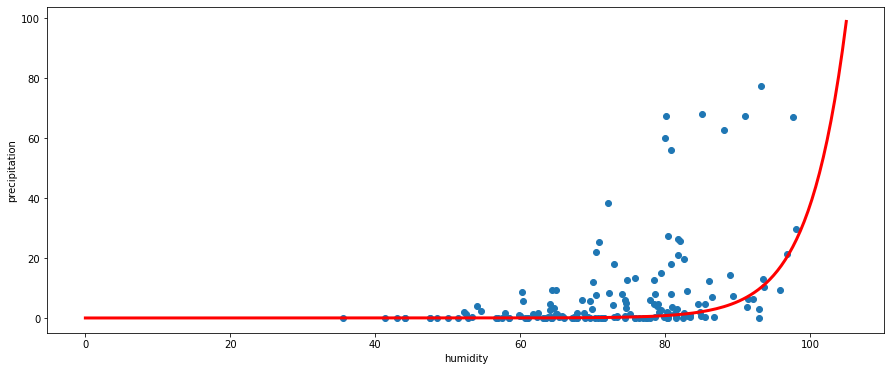

In [218]:
"""
Test 강수량 결측치
"""

null = test['precipitation'].isnull()

# columns = ['humidity', 'month', 'sunshine_sum']
columns = ['humidity']
x = np.array(test[columns].loc[null == False].values.tolist()).reshape(-1, 1)
y = test['precipitation'].loc[null == False] + 0.0001
y = np.array(y.map(np.log)).reshape(-1, 1)   # 값이 0인 데이터 방지 0.01

model = LinearRegression()
model.fit(x, y)

xs = np.linspace(0, 105, 200)
ys = np.exp(xs*model.coef_[0] + model.intercept_) - 0.0001

fig = plt.figure(figsize=(15, 6))
plt.xlabel("humidity")
plt.ylabel("precipitation")
plt.scatter(test['humidity'].loc[null == False].values.tolist(), test['precipitation'].loc[null == False])
plt.plot(xs, ys, 'r-', lw=3)

print(model.coef_[0], model.intercept_)

xs = np.array(test['humidity'].loc[null].values.tolist())
nan_pred = np.exp(xs*model.coef_[0] + model.intercept_) - 0.0001

In [219]:
test['precipitation'].loc[null] = nan_pred

In [220]:
test['precipitation'].isnull().sum()        # 테스트 데이터 강수량 결측치 0 확인

0

### Sunshine rate

Text(0, 0.5, 'sunshine_sum')

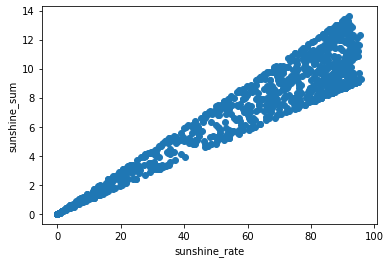

In [211]:
is_null_ss = train['sunshine_sum'].isnull()

x = train['sunshine_rate'].loc[is_null_ss == False]
y = train['sunshine_sum'].loc[is_null_ss == False]

plt.scatter(x, y)
plt.xlabel("sunshine_rate")
plt.ylabel("sunshine_sum")

# Linear 관계가 있는 것으로 보이므로 1차 Linear Regression으로 추정

In [212]:
"""
sunshine sum 결측치 처리 (Train)
"""

x = train['sunshine_rate'].loc[is_null_ss == False].values.reshape(-1, 1)
y = train['sunshine_sum'].loc[is_null_ss == False].values.reshape(-1, 1)

from sklearn.linear_model import LinearRegression

# LR 학습
lreg = LinearRegression()
lreg.fit(x, y)

pred = lreg.predict(train['sunshine_rate'].loc[is_null_ss].values.reshape(-1, 1))
pred = pred.squeeze(-1)
print(pred)
train['sunshine_sum'].loc[is_null_ss] = pred

print(train['sunshine_sum'].isnull().sum())             # 결측값 개수 0 확인

[0.18883871 0.18883871 0.18883871 0.18883871 0.18883871]
0


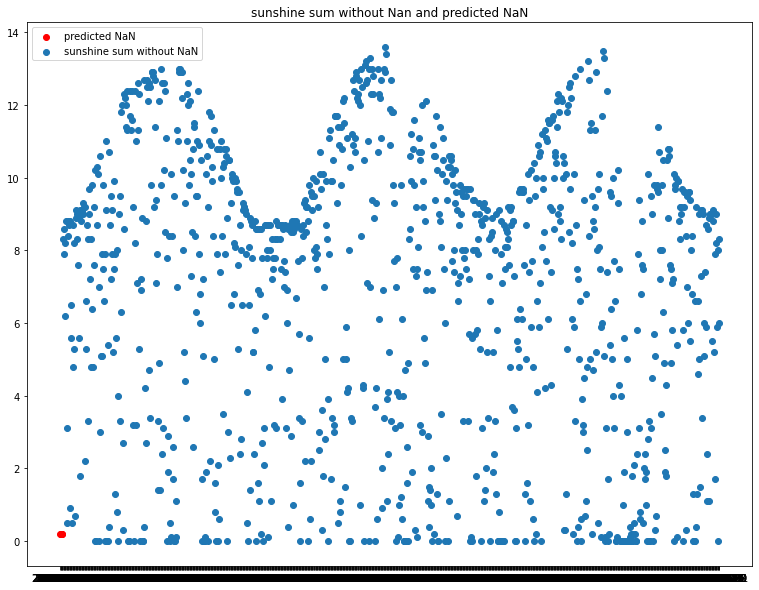

In [213]:
fig = plt.figure(figsize=(13,10))
plt.scatter(train_date.loc[is_null_sum], train['sunshine_sum'].loc[is_null_sum], color='red', label="predicted NaN")    # 결측치 예측값
plt.scatter(train_date.loc[is_null_sum == False], train['sunshine_sum'].loc[is_null_sum == False], label="sunshine sum without NaN")
plt.title("sunshine sum without Nan and predicted NaN")
plt.legend()
plt.show()

# LR로 추정한 NaN 값

   precipitation  temp_mean  temp_highest  temp_lowest  PM10  PM2.5  humidity  \
6            NaN      -14.5          -8.4        -16.5  41.0   13.0      49.9   

   sunshine_sum  sunshine_rate  wind_mean  wind_max  year  month  day  
6           NaN            0.0        4.1       8.3  2021      1    7  
0


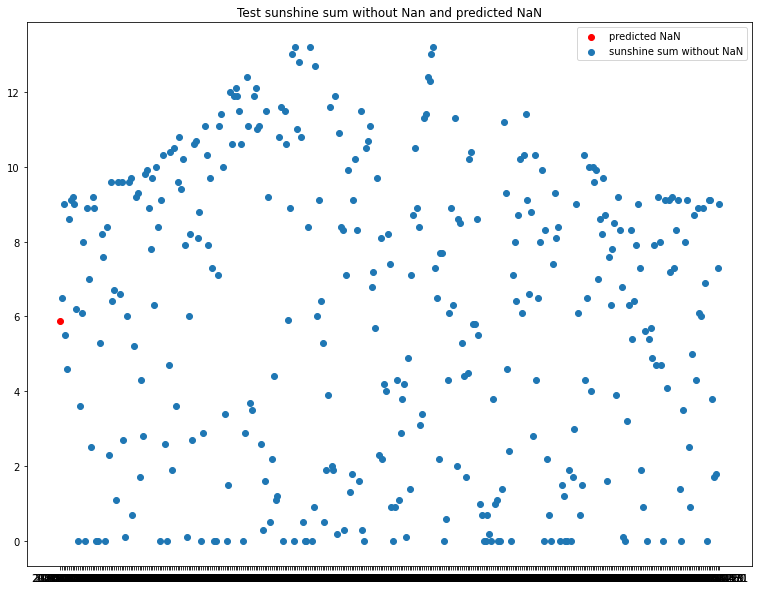

In [214]:
"""
테스트 sunshine sum mean으로 채움
"""
is_null_ss = test['sunshine_sum'].isnull()
print(test.loc[is_null_ss])

fig = plt.figure(figsize=(13,10))
pred = test['sunshine_sum'].loc[(test['year'] == 2021) & (test['month'] == 1)]
pred = np.mean(pred)
plt.scatter(test_date.loc[is_null_ss], pred, color='red', label="predicted NaN")
plt.scatter(test_date.loc[is_null_ss == False], test['sunshine_sum'].loc[is_null_ss == False], label="sunshine sum without NaN")
plt.title("Test sunshine sum without Nan and predicted NaN")
plt.legend()

test['sunshine_sum'].loc[is_null_ss] = pred

print(test['sunshine_sum'].isnull().sum())       # 결측값 개수 0 확인

# 추정한 NaN 값 (빨간 점)

### PM10, PM2.5

In [215]:
# PM10, PM2.5, sunshine_sum 결측치 채우기 in train

train["PM10"] = train["PM10"].fillna(train["PM10"].mean())
train["PM2.5"] = train["PM2.5"].fillna(train["PM2.5"].mean())

In [221]:
train.isnull().sum()

precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
year             0
month            0
day              0
dtype: int64

In [222]:
test.isnull().sum()

precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
year             0
month            0
day              0
dtype: int64

## Feature 추가하기
- Hoiday 피쳐 추가

In [224]:
"""
Train
"""
from datetime import datetime
date = train['year'].map(str)+'-'+train['month'].map(str)+'-'+train['day'].map(str)
df = pd.DataFrame(columns=['holiday', 'dayofweek'])

dateDict = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}

for d in date:
    datetime_date = datetime.strptime(d, '%Y-%m-%d')
    week = datetime_date.weekday()
    if (week == 5) | (week == 6):
        holi = 1
    else:
        holi = 0
    dow = dateDict[week]
    
    df = df.append({'holiday': holi, 'dayofweek': dow}, ignore_index=True)

train['holiday'] = df['holiday']        # 주말
train['dayofweek'] = df['dayofweek']    # 요일(참고용)
    

In [225]:
"""
Test
"""

from datetime import datetime
date = test['year'].map(str)+'-'+test['month'].map(str)+'-'+test['day'].map(str)
df = pd.DataFrame(columns=['holiday', 'dayofweek'])

dateDict = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}

for d in date:
    datetime_date = datetime.strptime(d, '%Y-%m-%d')
    week = datetime_date.weekday()
    if (week == 5) | (week == 6):
        holi = 1
    else:
        holi = 0
    dow = dateDict[week]
    
    df = df.append({'holiday': holi, 'dayofweek': dow}, ignore_index=True)
    
    
test['holiday'] = df['holiday'].map(int)
test['dayofweek'] = df['dayofweek']

In [226]:
train[:5]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,holiday,dayofweek
0,0.001120,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1,0,mon
1,0.002060,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2,0,tue
2,0.002192,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3,0,wed
3,0.002531,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,4,0,thu
4,0.007525,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,5,0,fri


In [227]:
test[:5]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day,holiday,dayofweek
0,0.035552,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1,2021,1,1,0,fri
1,0.000157,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4,2021,1,2,1,sat
2,0.000805,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5,2021,1,3,1,sun
3,0.000000,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,3.2,2021,1,4,0,mon
4,0.000000,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,5.7,2021,1,5,0,tue


# 2. Predict

## 모델 구성 및 실험
- DeterministicProcess로 시계열 데이터의 추세(trend)를 찾고 GBR로 학습
- 2018\~2019, 2019\~2020년도 각 월별 증가량 추이

In [228]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [235]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

train NMAE:  0.13273748023012888


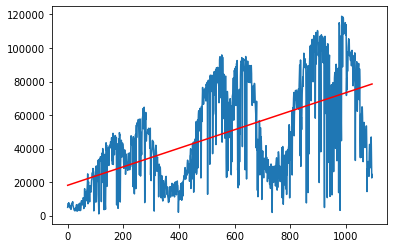

In [304]:
# GBR
columns = ['precipitation', 'temp_highest', 'PM2.5', 'sunshine_sum', 'holiday', 'wind_max', 'month']
x = train[columns]
y = train['rental']

x_test = test[columns]

order = 1
dp = DeterministicProcess(index=x.index, constant=True, order=order, drop=True)
output = dp.in_sample()

train_trends = []
test_trends = []
train_pred = []
test_pred = []

test_const = [1 for i in range(x_test.shape[0])]
test_trend = np.arange(output['trend'].max(), output['trend'].max()+x_test.shape[0])

output_test = pd.DataFrame([test_const, test_trend]).T
output_test.columns = ['const', 'trend']
output_test.index = x_test.index

lm = LinearRegression()
lm.fit(output, y)

trend_train = lm.predict(output)
trend_test = lm.predict(output_test)

train_trends.append(trend_train)
test_trends.append(trend_test)

plt.plot(y)
plt.plot(x.index, trend_train, 'r-')
y_delta = y / trend_train

gbr= GradientBoostingRegressor()
gbr.fit(np.array(x), y_delta)

#     print(gbr.get_params())
#     gbr_params = {'max_depth' : [3, 4, 6, 8,10] , 'n_estimators': [12,24,32,100,300, 400,600], 'learning_rate':[0.1, 0.2, 0.5, 1]}
#     grid_search_gbr = GridSearchCV(estimator = gbr, param_grid = gbr_params, cv = 10)

#     grid_search_gbr.fit(np.array(x), y_delta)
#     best_gbr = grid_search_gbr.best_estimator_

#     best.append(best_gbr)

#     features = gbr.feature_importances_
#     idx = np.argsort(features)
#     print(columns[idx])

gbr_train = gbr.predict(np.array(x))
gbr_test = gbr.predict(np.array(x_test))

train_pred.append(gbr_train)
test_pred.extend(gbr_test)

print("train NMAE: ", NMAE(np.array(y), gbr_train * trend_train))

submit['rental'] = test_pred * trend_test
submit.to_csv("./dataset/submission_final.csv", sep=',', na_rep="NaN", index=False)